Here I present you a **CNN Model using Keras (TensorFlow as backend)** to train a model with **CHEST X-RAY COVID IMAGES**. This model's **ACCURACY is 90%** which can be improved further by optimizing it's hyperparameters. However, it depends on one's computational power. Also, if you notice, it's **RECALL SCORE is 99%** which tells a lot about this model's efficiency in **COVID CASES**.

I will give you step by step explanation of how we arrived at this mind-blowing accuracy and recall scores! FOLLOW ME.

Let's call the necessary libraries and set the seed to 232. This is to reproduce the same results whenever we run the model.

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import exposure

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import numpy as np
from skimage import exposure
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions


seed = 232
np.random.seed(seed)


Using TensorFlow backend.


Setting the path location to 'input_path' variable.

Now, let's look at the images in the given folders.

There are 3 default folders on Kaggle on any given dataset. In this case, we have images which are labeled as **NORMAL AND COVID** inside **TRAIN, TEST, AND VALIDATION** folders. Let's look at one image from all the 3 folders which are labeled as NORMAL AND PNEUMONIA. 

***Let's see if you can identify any differences between NORMAL and COVID infected images. Can you? Majority of us cannot. If you do, then you've a good future as a radiologist!***

Let's move on.

In [2]:
input_path = "C:\\Users\\Cloudy\\Desktop\\c4next\\chest_xray\\"

Now, let's take a look at how many NORMAL and COVID images are in each TRAIN, VAL, TEST folders.

Apparently, not many! That's the case with any medical imagery. You wouldn't get too many images for training you model unless you've a large database of that disease. It's difficult to acquire them too. We gotta work with what we have and produce best results.

In [14]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '\\NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '\\covid'))
    print('Set: {}, normal images: {}, covid  images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, covid  images: 53
Set: val, normal images: 9, covid  images: 6
Set: test, normal images: 234, covid  images: 7


The next few steps include:
1. **Data Augmentation**
1. **Feed training and testing images to the network**
1. **Create labels for the images**

The practice of data augmentation is an effective way to increase the size of the training set. Augmenting the training examples allow the network to “see” more diversified data points during training. Please read more about Data Augmentation to get a better understanding on what it does to our training set.

Then we defined a couple of data generators: one for training data, and the other for validation data. A data generator is capable of loading the required amount of data (a mini batch of images) directly from the source folder, convert them into training data (fed to the model) and training targets (a vector of attributes — the supervision signal).

In [4]:

from keras.layers.core import Lambda
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/covid/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            
            img = plt.imread(input_path+'test'+cond+img)

            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/covid/':
                label = 1
            test_data.append(img)
            
            
            test_labels.append(label)
          
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

Let's create some constants so we don't have to repeat these numbers but instead use only the assigned names.

In [5]:
img_dims = 150

epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 1394 images belonging to 2 classes.
Found 241 images belonging to 2 classes.


Checking the assigned constants and shape.

In [6]:
test_data.shape

(241, 150, 150, 3)

Import **InceptioV3 weights** since we're training this model with pre-trained weights.

Set the Dropout rate to 0.5 for the model. This Dropout literally drops out or switches off few neurons in order to generalise the model for unknown data.

We're using **Sigmoid function** which suits best for the **Output Layer**.

**Adam Optimizer** for Optimization, **Binary Crossentropy** since we have 2 labels.

In [7]:

inputs = Input(shape=(img_dims, img_dims, 3))

from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(img_dims, img_dims, 3))
x = base_model.output

x = Dropout(0.5)(x)
from keras.layers import GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1,activation = 'sigmoid')(x)

# Creating model and compiling
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

We've also set 'Learning Rate(lr)' (which means how big a step we take while reaching to Global/Local Minima) and 'Early Stopping' (this makes sure when to stop overfitting as the model learns from the trained data while fitting the images on validation set).

Also, make sure to save your best weights, that is, whenever you've good/best accuracy level. So that, model can start from the learned weights instead of learning from scratch everytime the iteration starts.

Let's look at our model's summary.

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

**TIME TO FIT THE MODEL.**

**FINALLY !!!!!**

In [9]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
43/43 [==============================] - 68s 2s/step - loss: 0.6163 - acc: 0.8004 - val_loss: 0.3611 - val_acc: 0.9688
Epoch 2/10
43/43 [==============================] - 47s 1s/step - loss: 0.3447 - acc: 0.9673 - val_loss: 0.2174 - val_acc: 0.9713
Epoch 3/10
43/43 [==============================] - 45s 1s/step - loss: 0.2092 - acc: 0.9820 - val_loss: 0.1738 - val_acc: 0.9856

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
43/43 [==============================] - 44s 1s/step - loss: 0.1236 - acc: 0.9864 - val_loss: 0.1347 - val_acc: 0.9809
Epoch 5/10
43/43 [==============================] - 42s 987ms/step - loss: 0.1026 - acc: 0.9927 - val_loss: 0.0850 - val_acc: 0.9952

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
43/43 [==============================] - 42s 986ms/step - loss: 0.0822 - acc: 0.9964 - val_loss: 0.0875 - val_acc: 0.9856
Epoch 7/10
43/43 [==============================] - 

DONE !!!

Let's visualize this training on a graph.

dict_keys(['lr', 'val_acc', 'val_loss', 'loss', 'acc'])


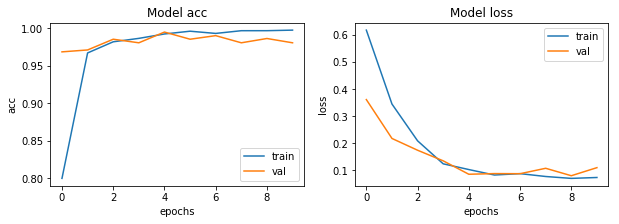

In [10]:


print(hist.history.keys())

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


As is with every model, training accuracy is almost touching to 100% whereas Validation accuracy is lowered. But, if you notice, the Loss has significantly reduced on first epoch itself! That's a good sign!

Now, let's see some predictions and other results on **Test Dataset.**

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[231   3]
 [  0   7]]

TEST METRICS ----------------------
Accuracy: 98.7551867219917%
Precision: 70.0%
Recall: 100.0%
F1-score: 82.3529411764706

TRAIN METRIC ----------------------
Train acc: 99.78


In [12]:
import seaborn as sn
import pandas as pd

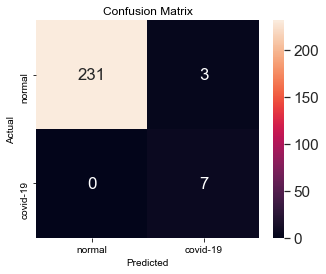

In [13]:
df_cm = pd.DataFrame(cm, index = ('normal', 'covid-19'), columns = ('normal', 'covid-19'))
plt.figure(figsize = (5,4))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Less than 5 PNEUMONIA cases are predicted as NORMAL cases !!!! THAT SAYS SOMETHING ABOUT THIS MODEL !!!

Recall Score in Medical Diagnosis plays an important role as it might sometimes depend on someone's lives!

Let's save the weights.